In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import warnings
import geobr
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
from shapely.geometry import mapping

warnings.filterwarnings("ignore")



In [10]:
def load_state():
    state = geobr.read_state(code_state="SP")
    state = state.to_crs("EPSG:4326")
    return state, state.unary_union

def open_dataset(data_dir, years, percentile, duration):
    file = f"heatwaves_{years[0]}_{years[-1]}_p{percentile}_threshold_events_{duration}_days_area_sao_paulo.nc"
    ds = xr.open_dataset(os.path.join(data_dir, file))
    ds = ds.rio.write_crs("EPSG:4326", inplace=False)
    ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
    return ds

def compute_mean_events(ds, state):
    years = ds["year"].values
    mean_event_days = {}
    for year in years:
        data = ds["event_dummy"].sel(year=year).sum(dim="valid_time")
        da_crop = data.rio.clip([mapping(state.unary_union)], state.crs, drop=True)
        mean_event_days[int(year)] = float(da_crop.mean().values)
    return pd.DataFrame.from_dict(mean_event_days, orient="index", columns=["mean_event_days"])


def plot_yearly_maps(ds, state, duration):
    years = ds["year"].values
    ncols = 4
    nrows = int(np.ceil(len(years) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()
    for i, year in enumerate(years):
        ax = axes[i]
        data = ds["event_dummy"].sel(year=year).sum(dim="valid_time")
        da_crop = data.rio.clip([mapping(state.unary_union)], state.crs, drop=True)

        levels = np.arange(0, 40, 2)
        im = da_crop.plot(ax=ax, cmap="Reds", levels=levels, add_colorbar=False, transform=ccrs.PlateCarree())
        ax.set_title(str(year))
        state.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
        ax.set_extent([-53.5, -44, -25.5, -19.5])
        gl = ax.gridlines(draw_labels=True, linewidth=0.2, color="gray", alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Días con evento")
    fig.suptitle(f"Ocurrencias anuales de olas de calor (2010–2025) - {duration} días", fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

def plot_bar_absolute(df_all):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df_all))
    width = 0.25
    ax.bar(x - width, df_all["3_days"], width, label="3 días")
    ax.bar(x, df_all["5_days"], width, label="5 días")
    ax.bar(x + width, df_all["7_days"], width, label="7 días")
    ax.set_xticks(x)
    ax.set_xticklabels(df_all.index, rotation=45)
    ax.set_ylabel("Promedio de días con evento")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_bar_percentage(df_all):
    df_pct = df_all.copy()
    df_pct["3_days"] = (df_pct["3_days"] / 365) * 100
    df_pct["5_days"] = (df_pct["5_days"] / 365) * 100
    df_pct["7_days"] = (df_pct["7_days"] / 365) * 100
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df_pct))
    width = 0.25
    ax.bar(x - width, df_pct["3_days"], width, label="3 días")
    ax.bar(x, df_pct["5_days"], width, label="5 días")
    ax.bar(x + width, df_pct["7_days"], width, label="7 días")
    ax.set_xticks(x)
    ax.set_xticklabels(df_pct.index, rotation=45)
    ax.set_ylabel("Porcentaje de días con evento (%)")
    ax.legend()
    plt.tight_layout()
    plt.show()


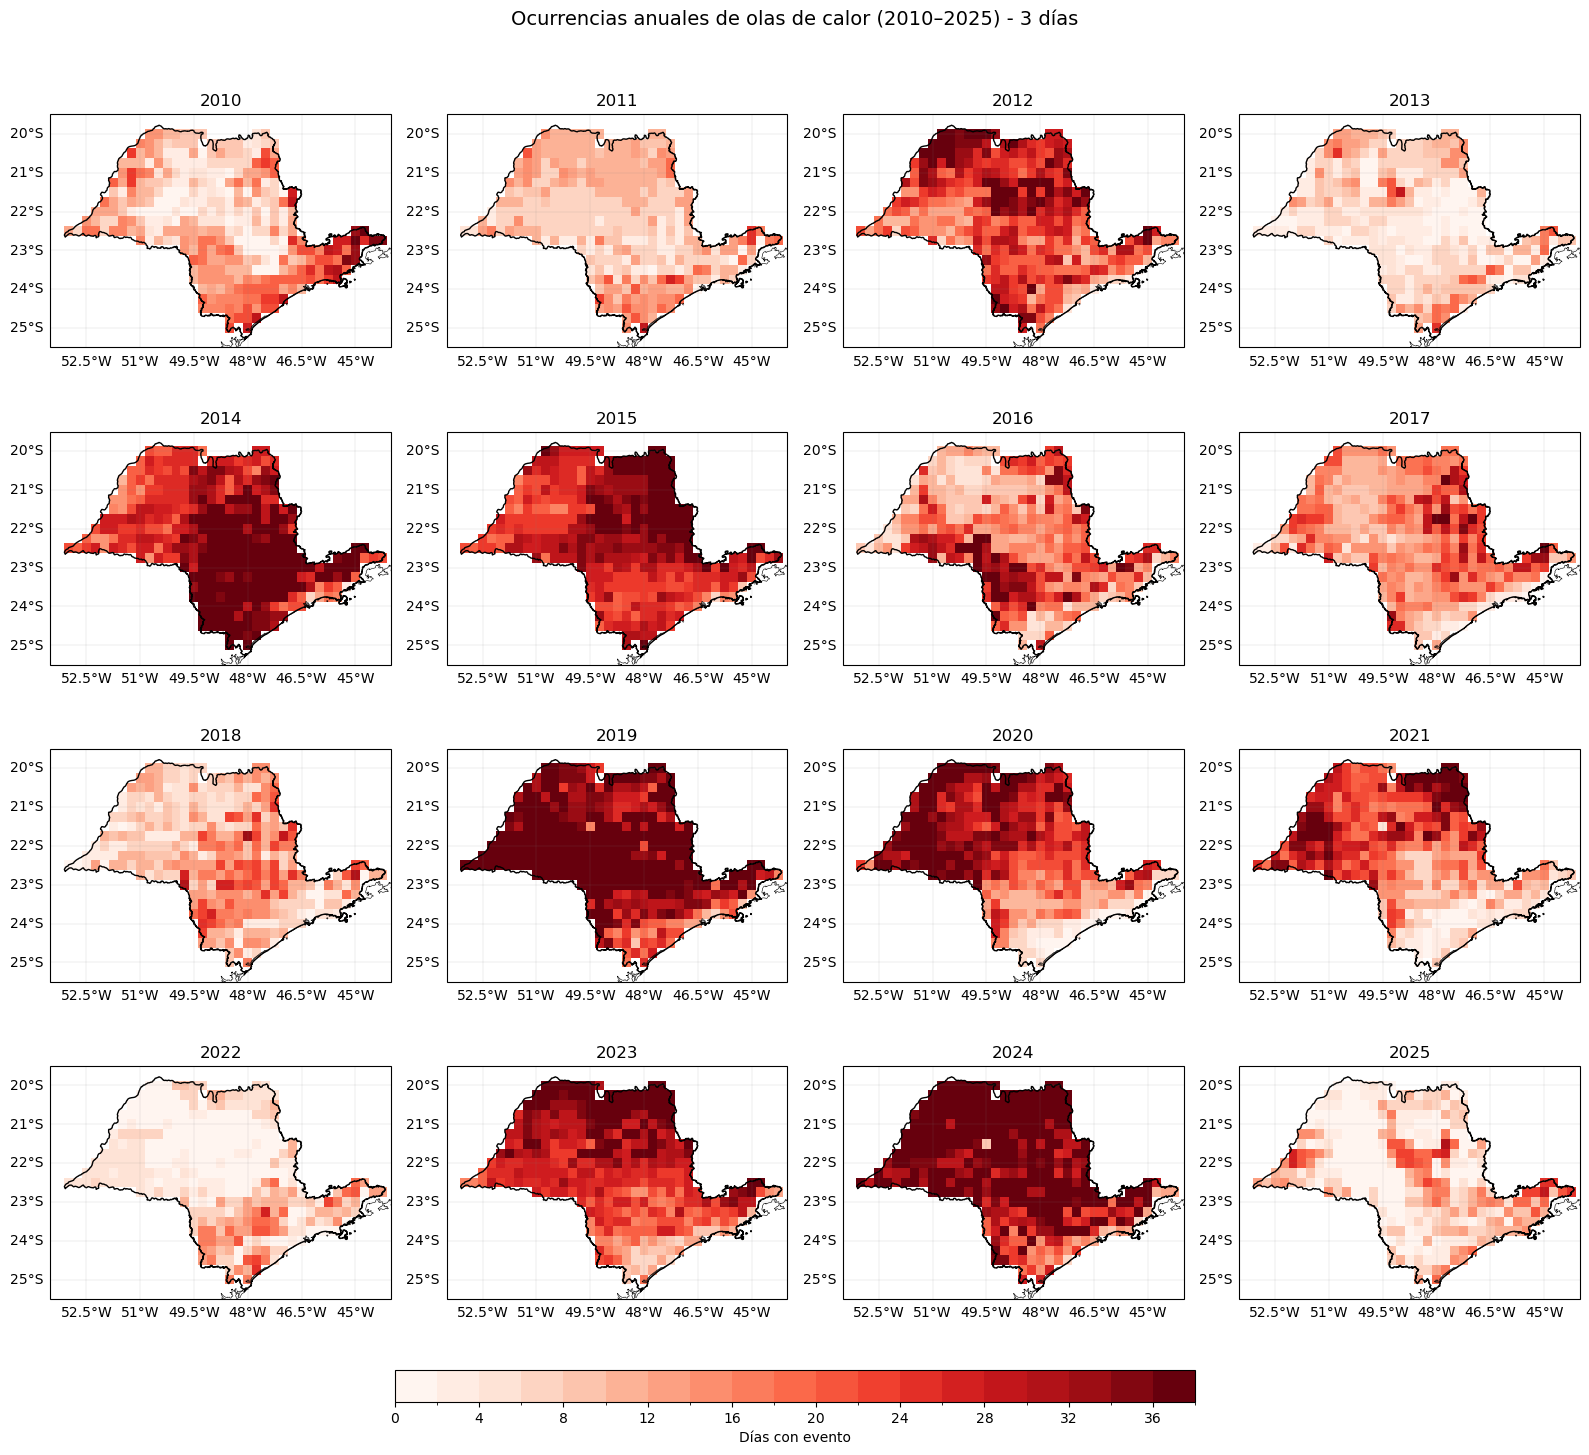

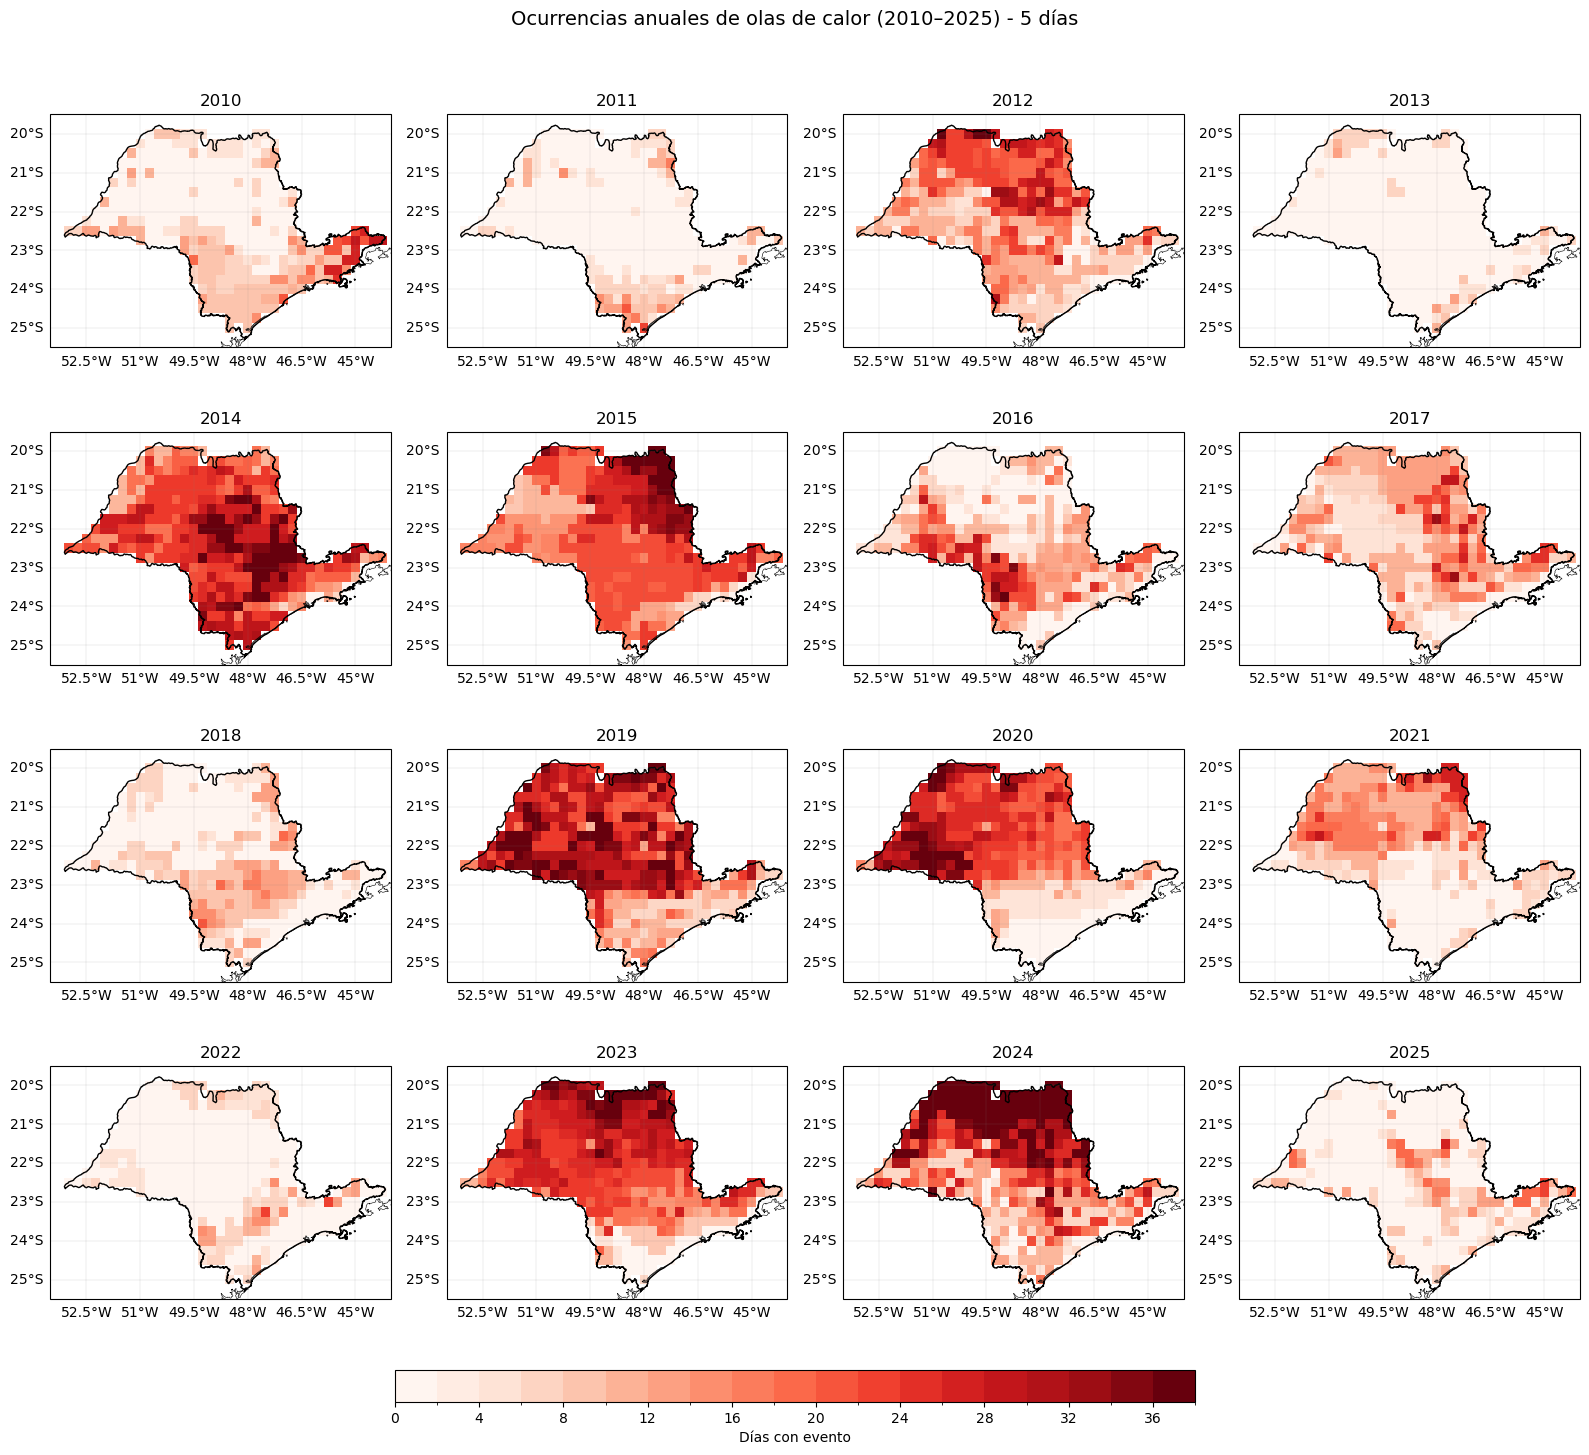

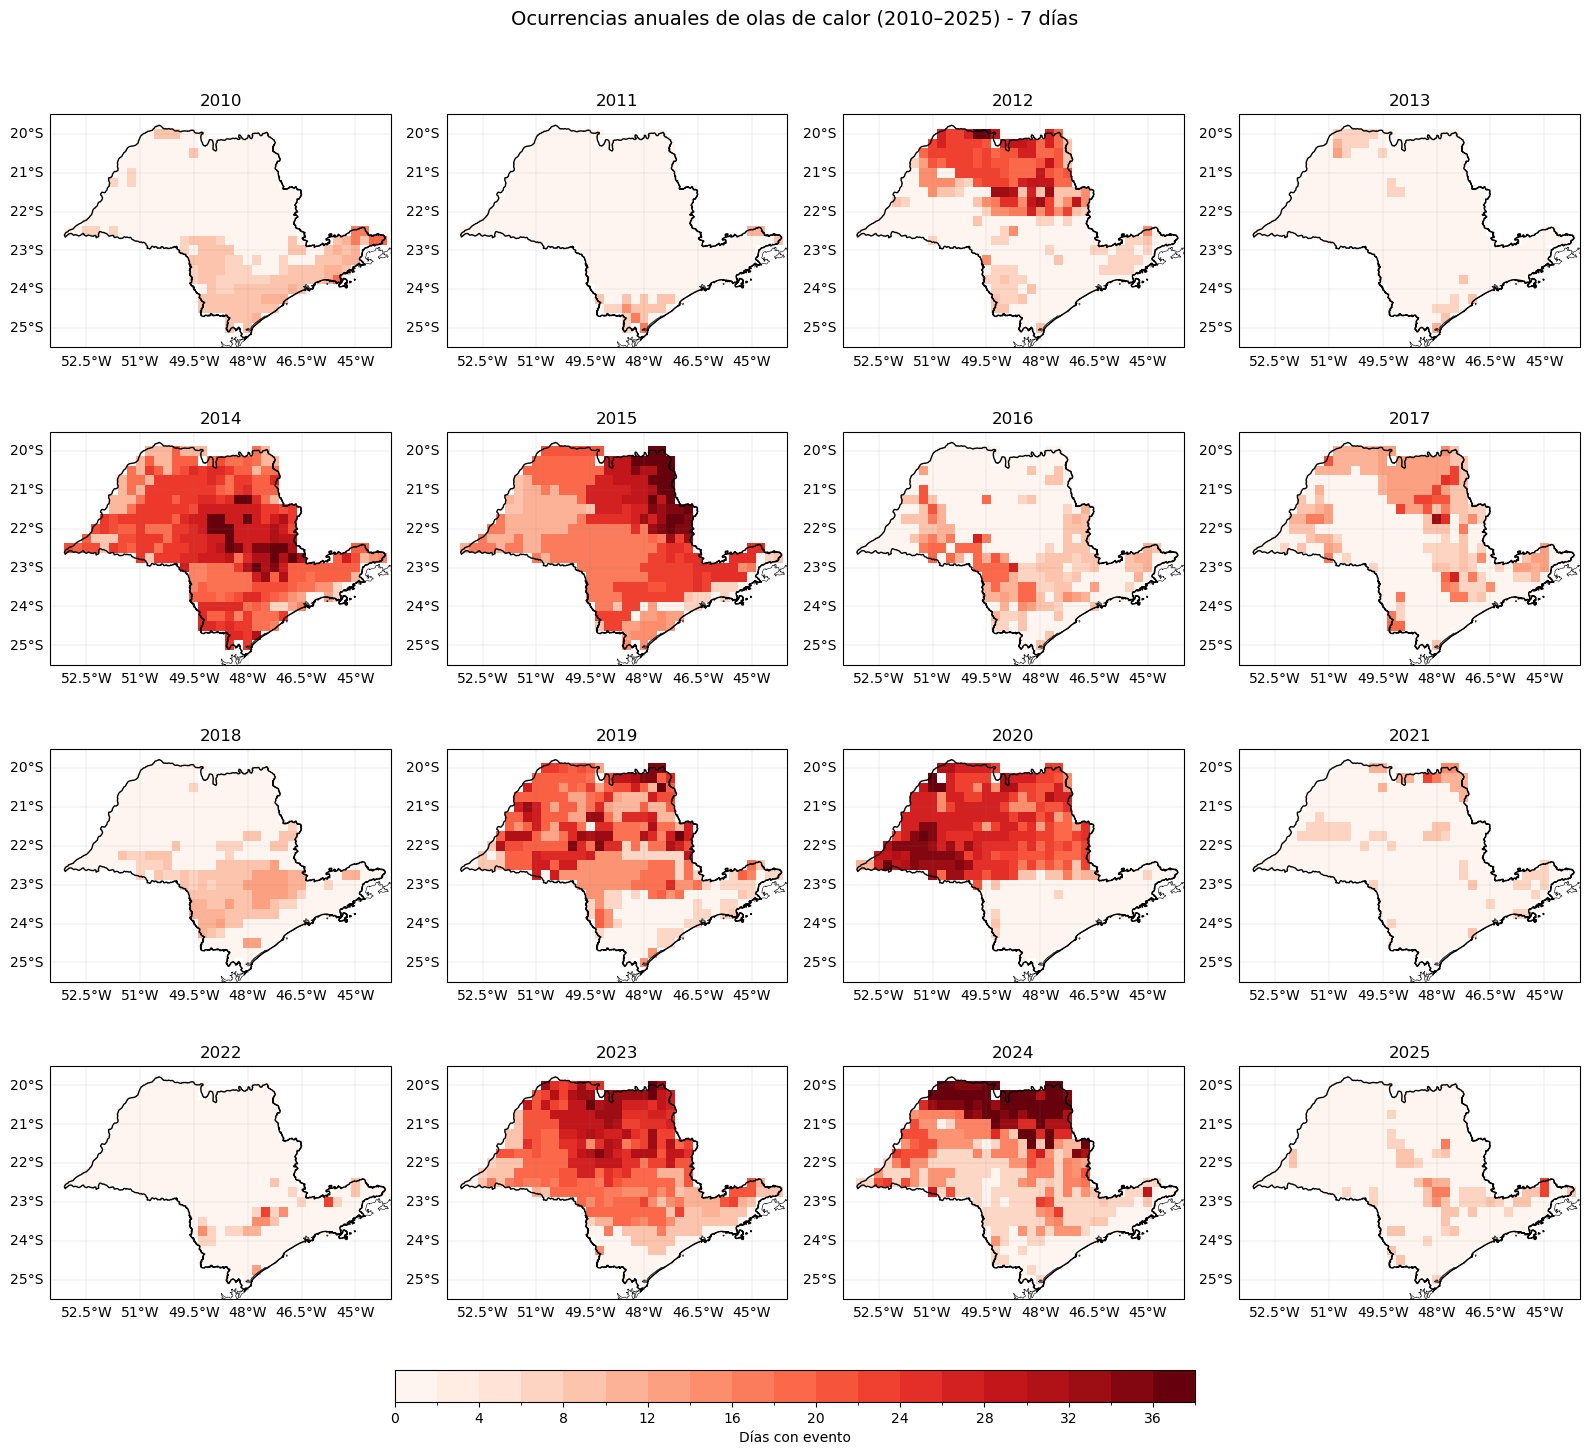

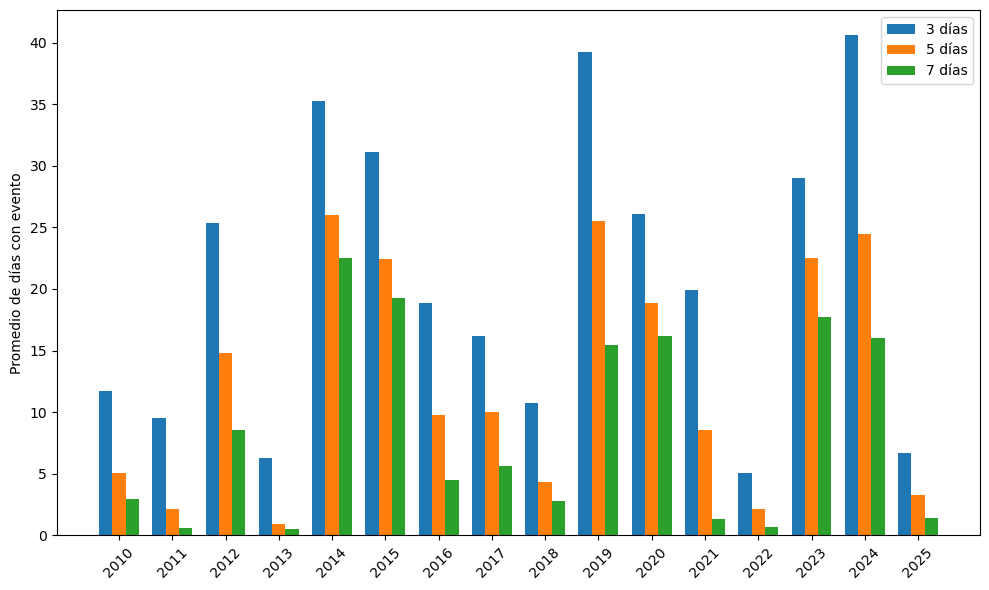

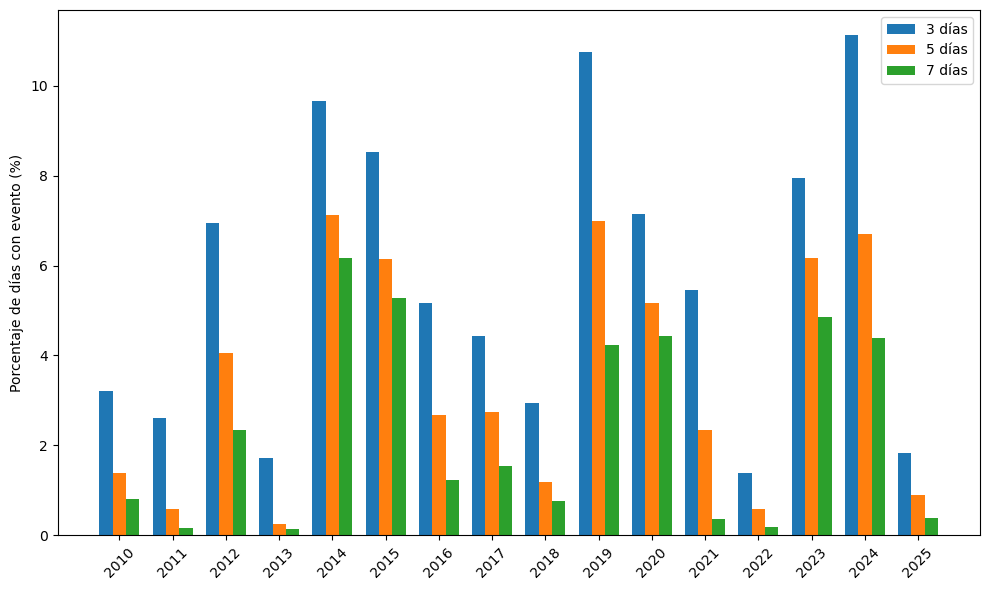

In [11]:

def main():
    list_years = np.arange(2010, 2026)
    durations = [3, 5, 7]
    percentile = 98
    data_processed_dir = "../data/processed/"
    state, polygon = load_state()
    df_all = pd.DataFrame(index=list_years)
    for d in durations:
        ds = open_dataset(data_processed_dir, list_years, percentile, d)
        plot_yearly_maps(ds, state, d)
        df_mean = compute_mean_events(ds, state)
        df_mean.columns = [f"{d}_days"]
        df_all = df_all.join(df_mean, how="left")
    plot_bar_absolute(df_all)
    plot_bar_percentage(df_all)
    return df_all

df_all = main()


In [ ]:
file_percentiles = 'tmax2m_mean_and_percentiles_2015_2024_area_6N_-74W_-34S_-33E.nc'
ds = xr.open_dataset(data_processed_dir + file_percentiles)

p98_mean = ds["t2m_p98"].mean(dim="doy").round(0) - 273.15  # Convert from Kelvin to Celsius

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.contourf(
    ds.longitude, ds.latitude, p98_mean,
    levels=np.arange(25, 42, 1), cmap="YlOrRd", extend="both", transform=ccrs.PlateCarree()
)

ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.STATES, linewidth=0.3)
ax.set_extent([-53.5, -44, -25.5, -19.5])
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-53.5, -44, -25.5, -19.5])

ax.tick_params(labelsize=7)

cbar = plt.colorbar(im, orientation="vertical", pad=0.05, aspect=50)
cbar.set_label("Temperature (°C)", fontsize=9)
cbar.ax.tick_params(labelsize=8)
plt.tight_layout()


In [13]:
# lat_point = 21.25
# lon_point = -87.5

# subset_ds = final_ds.sel(latitude=lat_point, longitude=lon_point, method="nearest")
# subset_percentile = p_percentile.sel(latitude=lat_point, longitude=lon_point, method="nearest")

# t_series_all = subset_ds["tmax2m"]
# event_series_all = subset_ds["event_dummy"]

# years = final_ds.year.values
# n_years = len(years)

# fig, axs = plt.subplots(n_years, 1, figsize=(14, 3.5 * n_years))

# if n_years == 1:
#     axs = [axs]

# for i, year in enumerate(years):
#     ax = axs[i]

#     time_index = pd.to_datetime(subset_ds.sel(year=year)["valid_time"].values)
#     t_series = t_series_all.sel(year=year).values
#     event_series = event_series_all.sel(year=year).values

#     doys = time_index.dayofyear
#     doys = np.where(doys > 365, 365, doys)
#     p90_series = [subset_percentile.sel(doy=day).item() for day in doys]

#     ax.plot(time_index, t_series, color='#F26457', linewidth=0.8, label='Tmax')
#     ax.plot(time_index, p90_series, color='darkgray', linestyle='--', linewidth=1.0, label='P90')
#     ax.set_title(f"Año {year}")
#     ax.set_ylabel("Temp (°C)")
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

#     for idx, is_event in enumerate(event_series):
#         if is_event:
#             ax.axvspan(time_index[idx], time_index[idx], alpha=0.2, color='red')

#     start_date = pd.Timestamp(f"{year}-01-01")
#     end_date = pd.Timestamp(f"{year}-12-31")
#     ax.set_xlim([start_date, end_date])


# axs[-1].set_xlabel("Fecha")
# axs[0].legend(loc='upper right', frameon=False)

# plt.tight_layout()
# plt.show()
